In [1]:
import nmp_util as nmp_util
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
data = pd.read_csv('data/SeaLevel_exclGIA.txt', names = ['date [y]','rise [mm]'], delimiter = r'\s+')
display(data)

,date [y],rise [mm]
0,1993.011526,-37.91
1,1993.038692,-40.95
2,1993.065858,-41.09
3,1993.093025,-43.38
4,1993.120191,-38.66
...,...,...
1173,2024.882992,70.97
1174,2024.910084,67.60
1175,2024.937176,65.14
1176,2024.964267,66.41


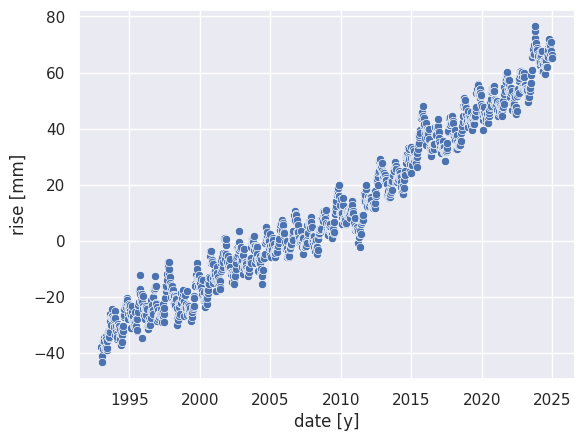

datapoints : 1178


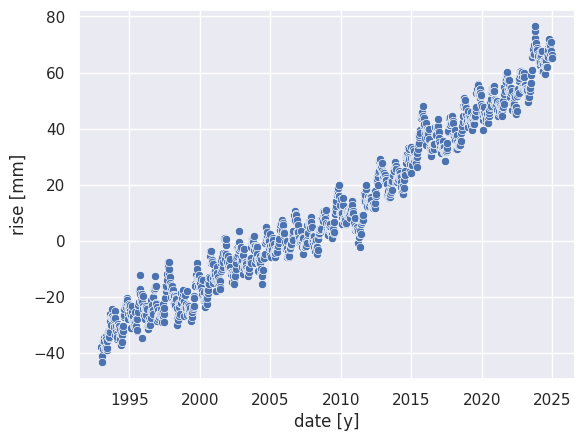

datapoings: 1178


In [3]:
sns.scatterplot(data = data, x = 'date [y]', y = 'rise [mm]')
plt.show()
print(f'datapoints : {len(data)}')
data = data.loc[nmp_util.get_inliers(data['rise [mm]']) & nmp_util.get_inliers(data['date [y]'])]
sns.scatterplot(data = data, x = 'date [y]', y = 'rise [mm]')
plt.show()
print(f'datapoings: {len(data)}')

In [4]:
rise = data['rise [mm]'].to_numpy()
date = data['date [y]'].to_numpy()

mean : 11.139906621392191
standard deviation : 29.011402928958656


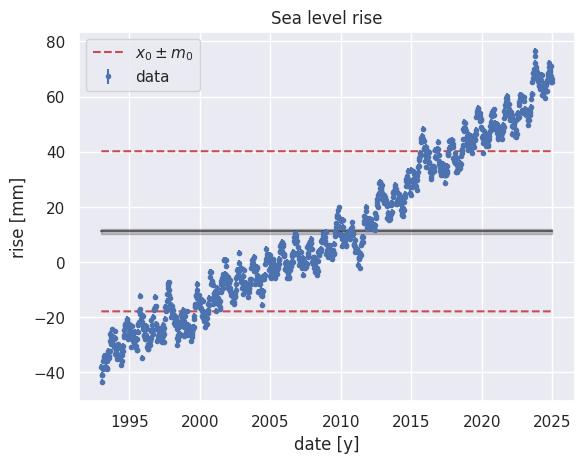

In [5]:
zero_order = nmp_util.PolyFunctionalModel(0)

zero_order.fit(date, rise)

plt.title('Sea level rise')
zero_order.plot()
sns.lineplot(x = date, y = zero_order.parameters[0]+zero_order.m_0, linestyle = '--',c='r')
sns.lineplot(x = date, y = zero_order.parameters[0]-zero_order.m_0, linestyle = '--', label = '$x_0\\pm m_0$',c='r')
plt.xlabel('date [y]')
plt.ylabel('rise [mm]')
plt.legend()

print(zero_order)

print(f'mean : {rise.mean()}')
print(f'standard deviation : {rise.std()}')
plt.show()

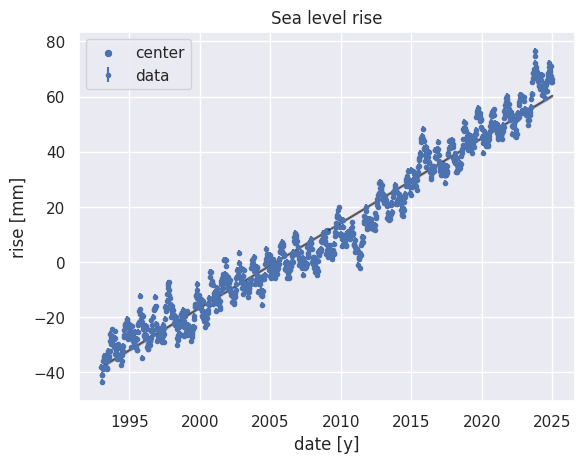

In [6]:
first_order = nmp_util.PolyFunctionalModel(1)

first_order.fit(date, rise)

x_center = date.mean()
y_center = rise.mean()

plt.title('Sea level rise')
first_order.plot()
sns.scatterplot(x = [x_center], y = [y_center], label = 'center')
plt.xlabel('date [y]')
plt.ylabel('rise [mm]')
plt.legend()
plt.show()

assert np.isclose(first_order.eval(x_center), y_center)

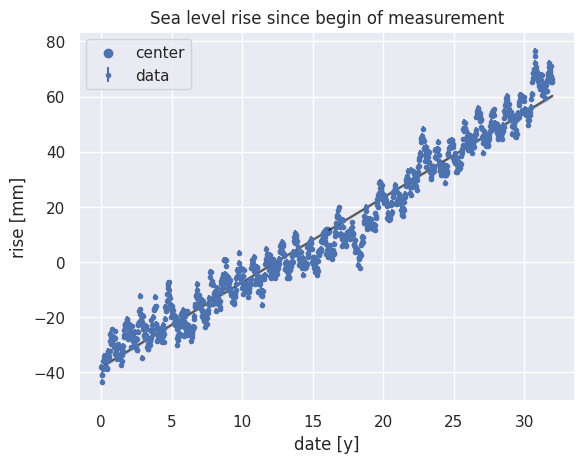

In [7]:
relative_date = date - date.min()

first_order.fit(relative_date, rise)

display(first_order)

x_center = relative_date.mean()
y_center = rise.mean()

plt.title('Sea level rise since begin of measurement')
first_order.plot()
plt.scatter(x_center, y_center, label = 'center')
plt.xlabel('date [y]')
plt.ylabel('rise [mm]')
plt.legend()
plt.show()

assert np.isclose(first_order.eval(x_center), y_center)

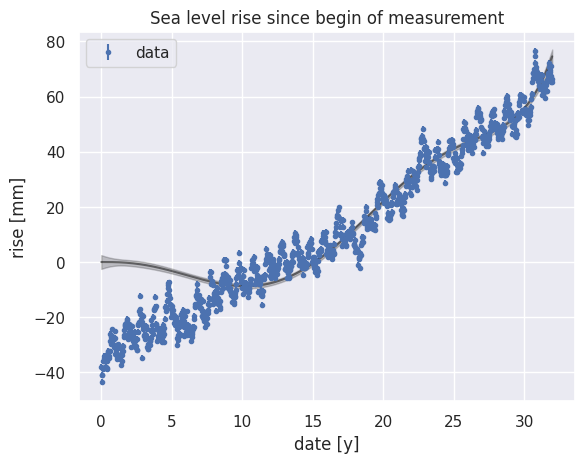

In [8]:
order = 6

poly_model = nmp_util.PolyFunctionalModel(order)

poly_model.fit(relative_date, rise)

display(poly_model)

plt.title('Sea level rise since begin of measurement')
poly_model.plot()
plt.xlabel('date [y]')
plt.ylabel('rise [mm]')
plt.legend()
plt.show()

In [9]:
m_0_alternative = np.sqrt((np.sum(rise**2) - np.sum(rise*poly_model.y_pred)) / (poly_model.dof))

print(m_0_alternative)
print(poly_model.m_0)

12.398712455608413
12.398712455608585


In [10]:
# compare the methods

np.random.seed(1)
x = np.random.random(1000)
y = np.random.random(1000)
degree = 7

#fit the direct model
f = nmp_util.PolyFunctionalModel(degree)
f.fit(x, y)

In [11]:
N = 500_000
test_x = np.random.rand(N)
test_y = np.random.rand(N)
order = 10

In [12]:
%timeit -n 10 -r 10 f.fit(test_x, test_y)

145 ms ± 11 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [13]:
# How fast is the poly fit if we use a P matrix?
import scipy.sparse
diag_elements = np.random.rand(N)
P = scipy.sparse.diags(diag_elements)
%timeit -r 10 f.fit(test_x, test_y, P)

try:
    P = P.todense()
    %timeit -r 10 f.fit(test_x, test_y, P)
except Exception as e:
    print(e)
    print('P is too large to convert to dense matrix.')

150 ms ± 10.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Unable to allocate 1.82 TiB for an array with shape (500000, 500000) and data type float64
P is too large to convert to dense matrix.
